## Start
*PyCaret used as a wrapper for Scikit-Learn models and functions*

In [4]:
# from time import time
# from tqdm import tqdm
from pathlib import Path

import pandas as pd
import numpy as np
np.random.seed(42)
# from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pycaret
pycaret.__version__

'3.1.0'

In [4]:
from pycaret.regression import *

**Steps** | **[Determine Best Model](#Determine-Best-Model)**

 - *prior studies*
   - *other notebooks*
     - **[preliminary studies - feature selection and normalization](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/16.3_Preprocessing-Training.ipynb)**
     - **[model selection, initial tuning](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/18.3_Modeling_selection.ipynb)**
     - **[outlier detection, method comparison](https://github.com/NBPub/Springboard/blob/main/Capstone%20Two/11.6_EDA_outlier-detection.ipynb)**
   - *at bottom of this notebook, can run after loading data*
     - **[tuning iterations](#Tuning-Studies)**
     - **[outlier removal](#Outlier-Detection)**
       - outlier removal improves for model performance, almost like a final data cleaning step
 - **load data, split**
 - **setup study with preprocessing: normalization and outlier removal**
    - *parameters determined in previous notebooks and outlier study, see links above*
 - **create two models: `CatBoost` and `GradientBoosting` Regressors**
   - *parameters determined in tuning study, see link above*
 - **blend and stack two models**
   - *prior studies with different preprocessing steps indicated a blend of the top 2 models (used here) may improve performance*
 - **compare CV results of the four models**
 - **choose top performing model, fit to entire dataset**

---
**Next | [Evaluate Residuals](#Residual-Analysis)**

**Other | [Interpret Model](#Other-Model-Plots)**

In [5]:
data = pd.read_parquet(Path('data/game_stats.parquet'))
X = data.iloc[:,6:-2]
y1 = data['home_margin'] # target for regression
y2 = data['home_win'] # target for classification

In [6]:
s1 = setup(pd.concat([X, y1], axis=1), target = 'home_margin', session_id = 42,
           train_size=0.75, verbose=False, normalize=True, 
           remove_outliers=True, outliers_threshold=0.01)

### Determine Best Model
 - previous studies suggest CatBoost and GradientBoosting Regressors have best performance
 - after fitting and tuning these two, how do their resulting stacks/blends perform?
   - 45 search iterations for tuning GBR
   - 0 search iterations for tuning CatBoost (don't tune)
 - choose top performing model to evaluate further: `CatBoost`

In [7]:
%%time
final_models = compare_models(include=['catboost','gbr'], n_select=2)

CPU times: total: 14.9 s
Wall time: 18.6 s


In [ ]:
final_models[1]

In [8]:
%%time
final_models[1] = tune_model(final_models[1],n_iter=45, verbose=False)

CPU times: total: 4.16 s
Wall time: 36.6 s


In [9]:
%%time
final_models.append(blend_models(final_models[0:2], verbose=False))
final_models.append(stack_models(final_models[0:2], verbose=False))

best = compare_models(final_models)
results = pull()

CPU times: total: 15.3 s
Wall time: 1min 45s


**Final Evaluation**

In [10]:
display(results.sort_values('R2',ascending=False).style\
        .background_gradient(subset=['R2'], cmap='viridis')
        .background_gradient(subset=['MAE','RMSE','MAPE'], cmap='viridis_r')
        .background_gradient(subset=['TT (Sec)'], cmap='bone_r')
        .highlight_max(subset=['R2'],  props='font-weight:bold')
        .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
        .format('{:.4f}', subset=results.columns[1:7]))

#### Plots

In [57]:
# results below without outlier removal
display(results.sort_values('R2',ascending=False).style\
        .background_gradient(subset=['R2'], cmap='viridis')
        .background_gradient(subset=['MAE','RMSE','MAPE'], cmap='viridis_r')
        .highlight_max(subset=['R2'],  props='font-weight:bold')
        .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
        .format('{:.4f}', subset=results.columns[1:7]))

In [11]:
final_models[3]

StackingRegressor(cv=5,
                  estimators=[('CatBoost Regressor',
                               <catboost.core.CatBoostRegressor object at 0x00000148BB782C50>),
                              ('Gradient Boosting Regressor',
                               GradientBoostingRegressor(learning_rate=0.05,
                                                         max_depth=6,
                                                         max_features='sqrt',
                                                         min_impurity_decrease=0.3,
                                                         min_samples_leaf=4,
                                                         min_samples_split=10,
                                                         n_estimators=270,
                                                         random_state=42,
                                                         subsample=0.7))],
                  final_estimator=LinearRegression(n_jobs=-1), n_jobs=-1,
                  passthrough=True)

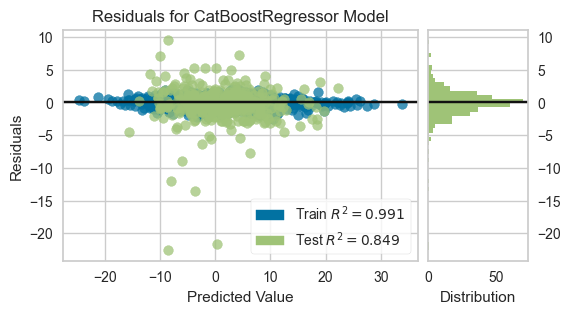

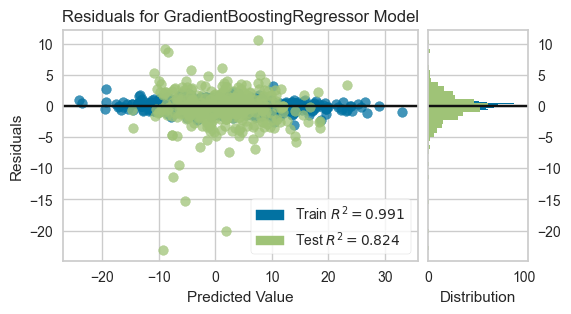

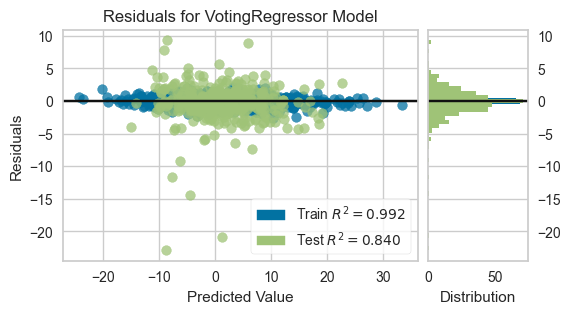

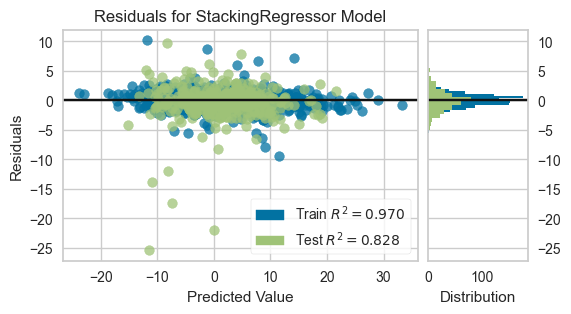

In [14]:
for m in final_models:
    plt.figure(figsize=(6,3))
    plot_model(m,'residuals')

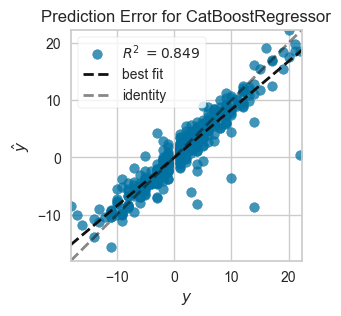

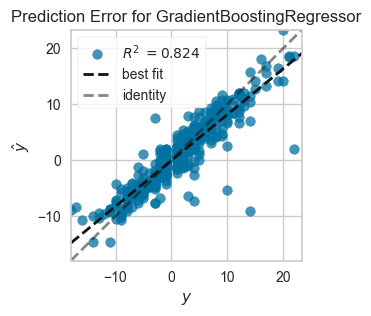

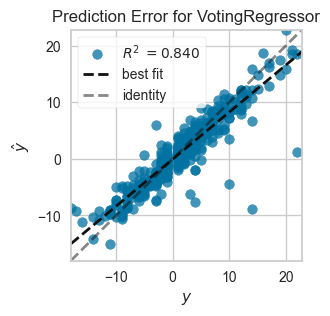

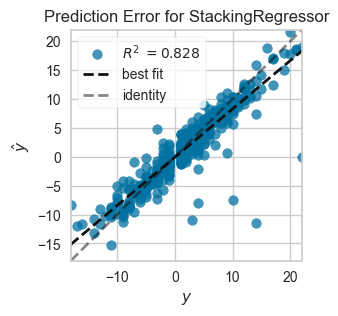

In [15]:
for m in final_models:
    plt.figure(figsize=(6,3))
    plot_model(m,'error')

### Residual Analysis
<font color="red">*Does it make sense to round predicted target values (convert to integer)?*</font>

 - finalize best performing model: `CatBoost`
 - evaluate residuals

In [17]:
best = finalize_model(best)

In [21]:
y1_pred = predict_model(best, X)

In [22]:
y1_pred = y1_pred['prediction_label']

In [24]:
residuals = np.abs(y1 - y1_pred)
raw_resid = y1-y1_pred

data['predicted_margin'] = y1_pred
data['residuals'] = residuals

**Worst predictions**
- **2997** is predicted to be a loss (`home_margin < 0`), actual result was win
  - curious result, as block_turnover_diff > 0

In [25]:
data.sort_values('residuals',ascending=False).head(7).T

1998                       2997  \
game                         2013-05-25-PHI-NJH         2023-07-21-MTL-BOS   
date                  2013-05-25 19:00:00+00:00  2023-07-21 19:00:00+00:00   
home                                Hammerheads                      Glory   
away                                    Phoenix                      Royal   
home_score                                   15                         18   
away_score                                   20                         12   
home_completions                            417                        125   
away_completions                            235                        124   
home_throws                                 477                        128   
away_throws                                 259                        133   
home_blocks                                  33                          3   
away_blocks                                  18                          2   
home_turnovers                               78                          3   
away_turnovers                               31                          9   
home_completion_rate                   0.874214                   0.976562   
away_completion_rate                   0.907336                   0.932331   
comp_rate_diff                        -0.033122                   0.044232   
block_turnover_diff                         -32                          7   
home_win                                  False                       True   
home_margin                                  -5                          6   
predicted_margin                     -11.820789                  -0.538433   
residuals                              6.820789                   6.538433   

                                           2964                       1690  \
game                    2022-11-12-allstar-game         2016-04-10-MIN-CHI   
date                  2022-11-12 16:00:00+00:00  2016-04-10 13:00:00+00:00   
home                               SW All-Stars                      Union   
away                               EC All-Stars                 Wind Chill   
home_score                                   24                         11   
away_score                                   42                         17   
home_completions                            264                        303   
away_completions                            241                         98   
home_throws                                 294                        348   
away_throws                                 262                        141   
home_blocks                                  12                         17   
away_blocks                                  18                         24   
home_turnovers                               30                         45   
away_turnovers                               21                         43   
home_completion_rate                   0.897959                    0.87069   
away_completion_rate                   0.919847                   0.695035   
comp_rate_diff                        -0.021888                   0.175654   
block_turnover_diff                         -15                         -9   
home_win                                  False                      False   
home_margin                                 -18                         -6   
predicted_margin                     -12.440597                  -1.193332   
residuals                              5.559403                   4.806668   

                                           1987                       1738  \
game                          2013-05-12-NY-TOR          2015-07-10-PHI-DC   
date                  2013-05-12 16:00:00+00:00  2015-07-10 18:30:00+00:00   
home                                       Rush                     Breeze   
away                                     Empire                    Phoenix   
home_score                                   16                

**Graphs**

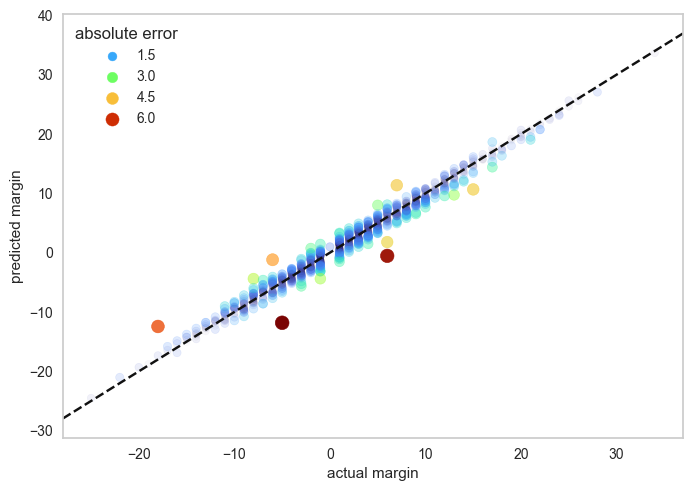

In [29]:
sns.scatterplot(x=y1, y=y1_pred, hue=residuals, 
                palette='turbo', edgecolor='face',
                size=residuals, alpha=residuals/residuals.max())
xlim = plt.xlim()
plt.plot(xlim,xlim, 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('predicted margin')
plt.xlabel('actual margin')
plt.grid()
plt.savefig('graphs/Model/final_predicted-vs-actual.png', bbox_inches='tight')
plt.show()

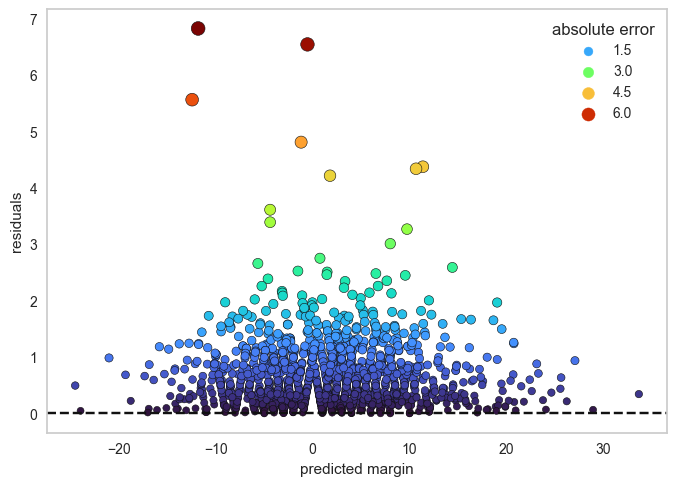

In [30]:
sns.scatterplot(x=y1_pred, y=residuals, hue=residuals, 
                palette='turbo', edgecolor='k',
                size=residuals)
xlim = plt.xlim()
plt.plot(xlim,[0,0], 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('residuals')
plt.xlabel('predicted margin')
plt.grid()
plt.savefig('graphs/Model/final_residual-vs-predicted.png', bbox_inches='tight')
plt.show()

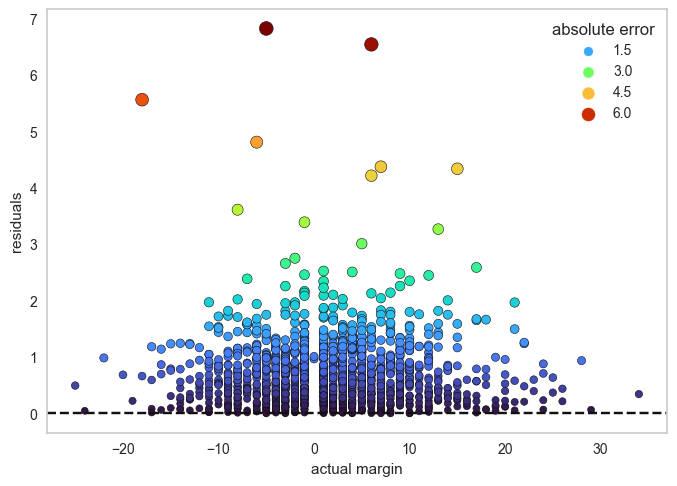

In [31]:
sns.scatterplot(x=y1, y=residuals, hue=residuals, 
                palette='turbo', edgecolor='k',
                size=residuals)
xlim = plt.xlim()
plt.plot(xlim,[0,0], 'k--')
plt.xlim(xlim)
plt.legend(title='absolute error')
plt.ylabel('residuals')
plt.xlabel('actual margin')
plt.grid()
plt.savefig('graphs/Model/final_residual-vs-actual.png', bbox_inches='tight')
plt.show()

Error not related to season. Early modeling attempts had greater error in 2012, 2013. Stat keeping was more suspect then.

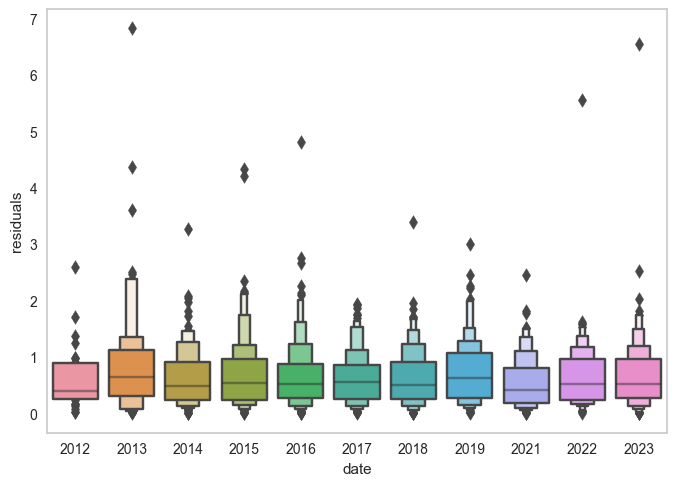

In [33]:
sns.boxenplot(data, y='residuals', x=data.date.dt.year)
plt.grid(axis='y')
plt.savefig('graphs/Model/final_residual-by-year.png', bbox_inches='tight')

plt.show()

Error by team's home and away games. 

It might be expected that teams that dominate (Empire) or get dominated (Mechanix) might have greater error than more average teams.
Similarly, teams that only played a few games might have more extreme results. Historical team results are shown in a table below the graph.

At a cursory glance, the error isn't influenced greatly by the teams playing. Quantifying this influence might be a usefull exercise to evaluate the AUDL teams.

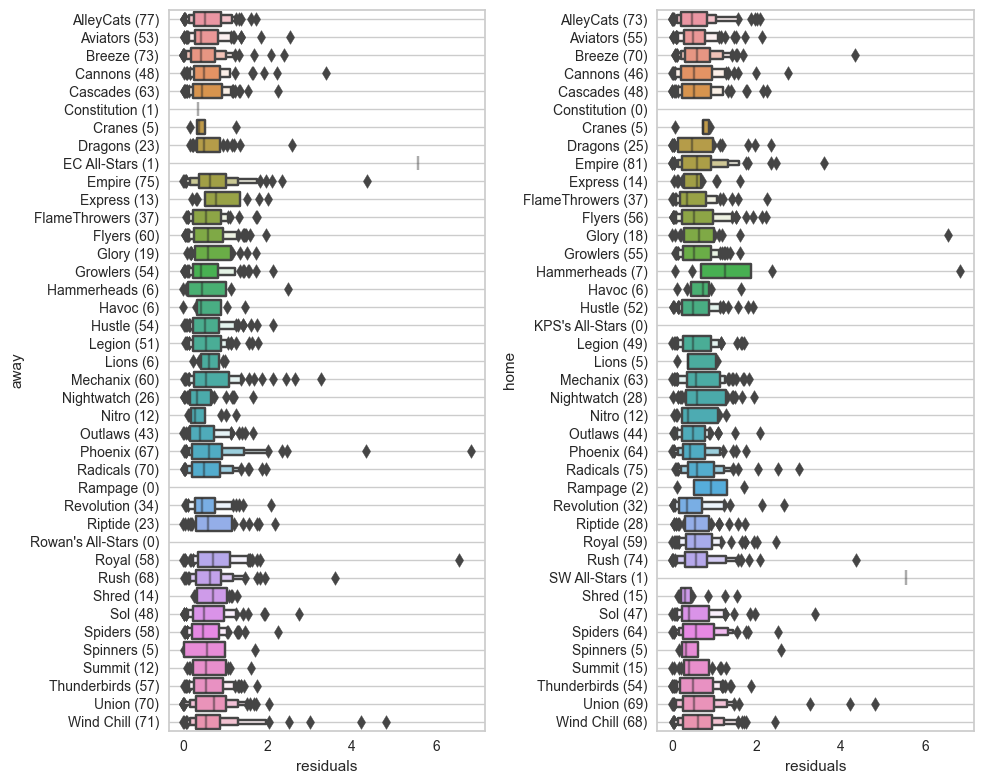

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8), tight_layout=True)

sns.boxenplot(data, x='residuals', y='away', ax=ax1)
ax1.grid()
ticks = ax1.get_yticks()
ax1.set_yticks(ticks = ticks, 
           labels=[f"{val[0]} ({val[1]})" for val in data.value_counts('away').sort_index().items()]
          )

sns.boxenplot(data, x='residuals', y='home', ax=ax2)
ax2.grid()
ticks = ax2.get_yticks()
ax2.set_yticks(ticks = ticks, 
           labels=[f"{val[0]} ({val[1]})" for val in data.value_counts('home').sort_index().items()]
          )

#fig['figsize'] = (12,10)
plt.savefig('graphs/Model/final_residual-by-team.png', bbox_inches='tight')
plt.show()

In [5]:
teams = pd.read_parquet('data/clean_1/team_info_2023-09-19.parquet')

In [15]:
display(teams.drop(columns=['primary','secondary']).sort_values('games', ascending=False).style
    .background_gradient(subset=['wins'], cmap='viridis_r')
    .background_gradient(subset=['losses'], cmap='viridis')
    .background_gradient(subset=['games'], cmap='bone'))

### Other Model Plots
- SHAP plots + feature importance for CatBoost final model
  - extract from pipeline
- will not execute cells with heavy JS plots

In [46]:
best

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['home_completions',
                                             'away_completions', 'home_throws',
                                             'away_throws', 'home_blocks',
                                             'away_blocks', 'home_turnovers',
                                             'away_turnovers',
                                             'home_completion_rate',
                                             'away_completion_rate',
                                             'comp_rate_diff',
                                             'block_turnover_diff'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('remove_outliers',
                 TransformerWrapper(transformer=RemoveOutliers(random_state=42,
                                                               threshold=0.01))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 <catboost.core.CatBoostRegressor object at 0x00000148BBC441C0>)])

In [47]:
best[4]

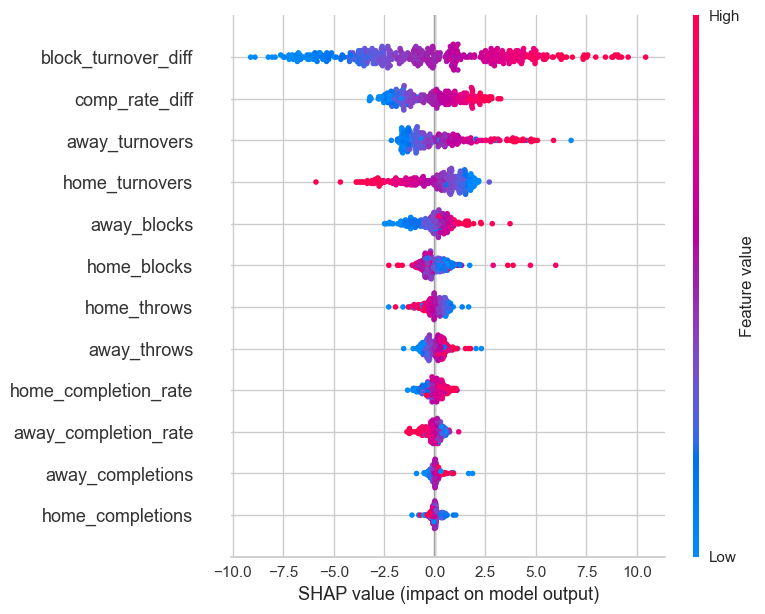

In [48]:
interpret_model(best[4],'summary')

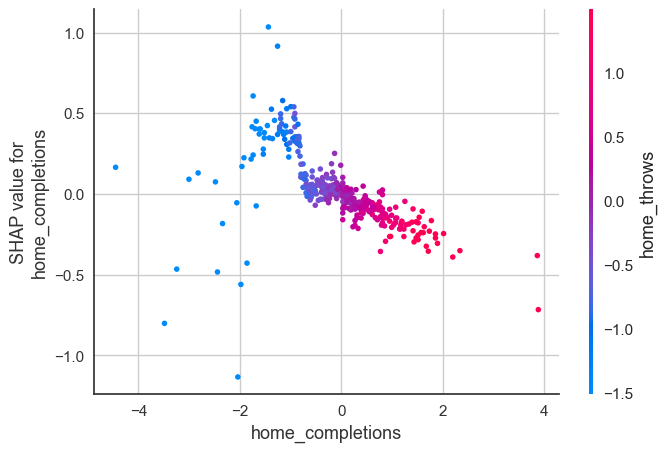

In [49]:
interpret_model(best[4],'correlation')

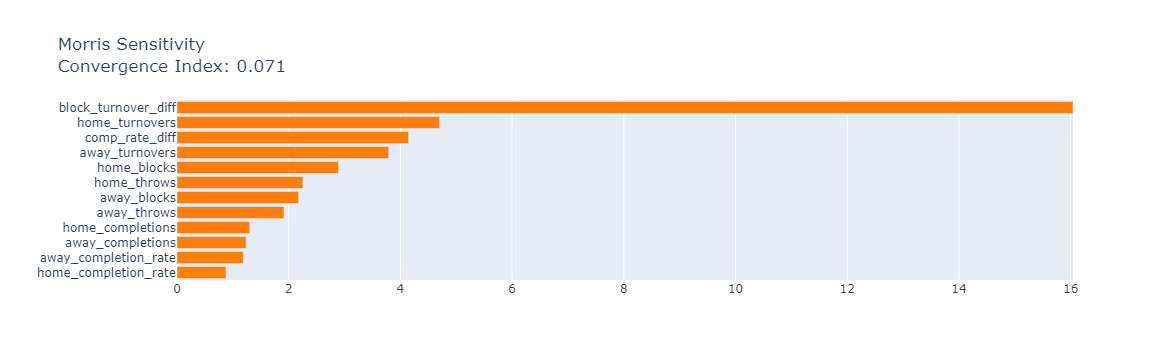

In [50]:
interpret_model(best[4],'msa')

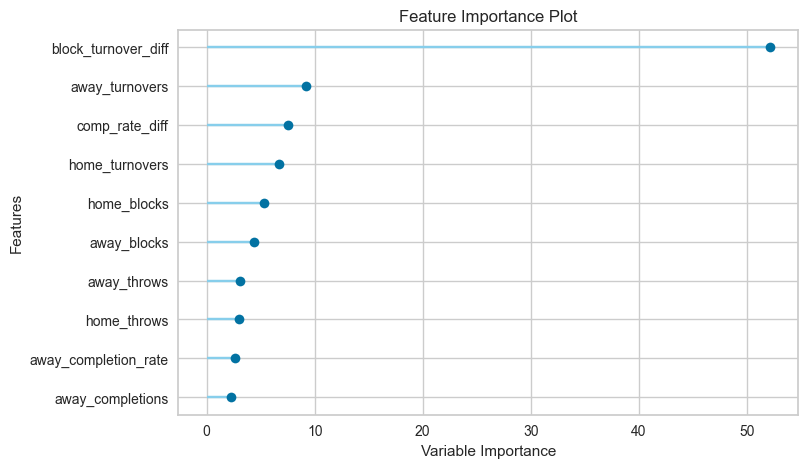

In [51]:
plot_model(best[4],'feature')

### Tuning Studies
Does tuning improve model? If so, how many iterations are required? Code provided below results, note time before running cells.

**Don't tune CatBoost, use `45` iterations for GradientBoost**

In [29]:
cbr_result

MAE     MSE    RMSE      R2   RMSLE    MAPE
0   1.5644  6.4476  2.4955  0.8877  0.4167  0.4867
10  1.7896  8.0305  2.7986  0.8587  0.4447  0.5604
20  1.6377  6.5825  2.5386  0.8848  0.4217  0.5192
30  1.6377  6.5825  2.5386  0.8848  0.4217  0.5192
60  1.6377  6.5825  2.5386  0.8848  0.4217  0.5192

In [44]:
gbr_result

MAE     MSE    RMSE      R2   RMSLE    MAPE
0   1.8106  7.7902  2.7576  0.8640  0.4358  0.5539
20  1.6921  7.0351  2.6108  0.8773  0.4302  0.5227
30  1.6921  7.0351  2.6108  0.8773  0.4302  0.5227
45  1.6742  6.8249  2.5817  0.8808  0.4213  0.5349
60  1.6742  6.8249  2.5817  0.8808  0.4213  0.5349
90  1.6742  6.8249  2.5817  0.8808  0.4213  0.5349

#### Code

In [30]:
gbr = create_model('gbr')

In [31]:
gbr_result = pull().loc['Mean']

In [33]:
gbr_result = pd.DataFrame(gbr_result).T.reset_index(drop=True)

In [35]:
%%time

for it in [20,30,45,60,90]:
    print('tuning with', it, 'iterations')
    gbr = tune_model(gbr,n_iter=it)
    gbr_result.loc[it] = pull().loc['Mean']

tuning with 20 iterations


Fitting 10 folds for each of 20 candidates, totalling 200 fits
tuning with 30 iterations


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
tuning with 45 iterations


Fitting 10 folds for each of 45 candidates, totalling 450 fits
tuning with 60 iterations


Fitting 10 folds for each of 60 candidates, totalling 600 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
tuning with 90 iterations


Fitting 10 folds for each of 90 candidates, totalling 900 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
CPU times: total: 17.3 s
Wall time: 1min 38s


### Outlier Detection
*`iforest` with threshold of `0.01` improves both models, can leave z-score normalization*

*for future, could be worth trying values in between 0.01 and 0.05*

In [65]:
_ = compare_models(include=['catboost','gbr'])
baseline = pull()
baseline

Model     MAE     MSE    RMSE      R2   RMSLE  \
catboost           CatBoost Regressor  1.5644  6.4476  2.4955  0.8877  0.4167   
gbr       Gradient Boosting Regressor  1.8106  7.7902  2.7576  0.8640  0.4358   

            MAPE  TT (Sec)  
catboost  0.4867     1.160  
gbr       0.5539     0.298

In [73]:
%%time
for condition in [('iforest','zscore'), ('iforest','robust'), ('lof','zscore'),('lof','robust')]:
    for threshold in [0.01, 0.05, 0.1]:
        setup(pd.concat([X, y1], axis=1), target = 'home_margin', session_id = 42,
              train_size=0.75, verbose=False, normalize=True, remove_outliers=True,
              outliers_threshold=threshold, outliers_method=condition[0], normalize_method=condition[1])
        _ = compare_models(include=['catboost','gbr'])
        r = pull()
        r.index = [f"{val}_{condition[0]}-{threshold}_{condition[1]}" for val in r.index]
        
        baseline = pd.concat([baseline, r])

CPU times: total: 3min 24s
Wall time: 2min 17s


In [86]:
for m_type in ['Gradient Boosting Regressor', 'CatBoost Regressor']:
    print(m_type, 'outlier removal study')
    display(baseline[baseline.Model==m_type].sort_values('R2',ascending=False).style\
        .background_gradient(subset=['R2'], cmap='viridis')
        .background_gradient(subset=['MAE','RMSE','MAPE'], cmap='viridis_r')
        .highlight_max(subset=['R2'],  props='font-weight:bold')
        .highlight_min(subset=['MAE','RMSE','MAPE'],  props='font-weight:bold')
        .format('{:.4f}', subset=baseline.columns[1:]))

Gradient Boosting Regressor outlier removal study


CatBoost Regressor outlier removal study
